In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from PIL import Image
import math
import itertools

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import torch.nn.functional as F

from itertools import count
from collections import defaultdict

import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE

In [3]:
USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 100
z_dim = 128
test_path = '/home/irfandw/Works/dataset/morph/image_1/'

In [4]:
test_dataset = ImageFolder(
        root=test_path,
        transform=torchvision.transforms.ToTensor()
    )
test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [5]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim=10, nc=3):
        super(Encoder, self).__init__()

        self.nc = nc
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 128, 4, 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, 4, 2, padding = 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            View((-1, 1024*4*4)),
        )

        self.mean = nn.Linear(1024*4*4, z_dim)
        self.logvar = nn.Linear(1024*4*4, z_dim)


    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        multi = torch.FloatTensor(std.size()).normal_().cuda()
        multi = Variable(multi)
        return multi.mul(std).add_(mean)


    def forward(self, x):
        b_size = x.size(0)

        h = self.encoder(x)
        
        mean, logvar = self.mean(h), self.logvar(h)

        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar


class Decoder(nn.Module):
    def __init__(self, z_dim=10, nc = 3):
        super(Decoder, self).__init__()
        
        self.nc = nc
        self.z_dim = z_dim

        self.decoder_lin = nn.Sequential(
            nn.Linear(z_dim, 1024*8*8),
            View((-1, 1024, 8, 8))
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, nc, 1)
        )
        
    def forward(self, x):
        h = self.decoder_lin(x)
        out = self.decoder_conv(h)
        return out


class VAE(nn.Module):
    """Encoder-Decoder architecture for both WAE-MMD and WAE-GAN."""
    def __init__(self, z_dim=128, nc=3):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.nc = nc

        self.encoder = Encoder(z_dim=z_dim, nc=nc)
        self.decoder = Decoder(z_dim=z_dim, nc=nc)

    
    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def _encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z
    
    def _decode(self, x):
        return self.decoder(x)

In [7]:
VAE_net = VAE(z_dim=128, nc=3)

if torch.cuda.is_available():
    VAE_net = VAE_net.cuda()

In [8]:
VAE_net.load_state_dict(torch.load('saved_model_x0/vae.pth'))

## Generate Images part

In [11]:
VAE_net.eval()
batchz = 100

genz = []

with torch.no_grad():
    for i in range(10):
        zx = torch.randn(batchz, z_dim)
        
        zx = zx.to(device)
        
        gen = VAE_net._decode(zx)

        genz.append(gen[0].cpu().numpy())

genz = np.array(genz)
genz = np.transpose(genz, (0, 2,3,1))

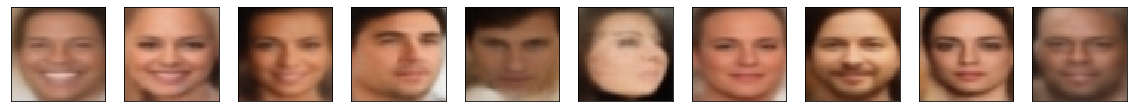

In [12]:
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(genz[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Autoencoder part

In [13]:
VAE_net.eval()

recons_images = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = VAE_net._encode(datax)
        decod = VAE_net._decode(z_encoded)

        recons_images.append(decod[0].cpu().numpy())

recons_images = np.array(recons_images)
recons_images = np.transpose(recons_images, (0, 2,3,1))

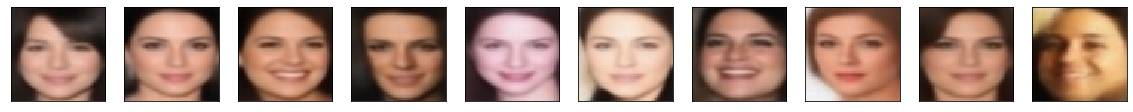

In [14]:
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(recons_images[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #plt.savefig('result/01-wae_128_recons_1.jpg', dpi=300, bbox_inches = 'tight')


## Morph

In [15]:
path_image1 = '/home/irfandw/Works/dataset/morph/image_1/'

path_image2 = '/home/irfandw/Works/dataset/morph/image_2/'


test_dataset1 = ImageFolder(
        root=path_image1,
        transform=torchvision.transforms.ToTensor()
    )
test_loader1 = DataLoader(
        test_dataset1,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )


test_dataset2 = ImageFolder(
        root=path_image2,
        transform=torchvision.transforms.ToTensor()
    )
test_loader2 = DataLoader(
        test_dataset2,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [16]:
VAE_net.eval()

z1 = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader1):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = VAE_net._encode(datax)
        z1.append(z_encoded[0].cpu().numpy())

z1 = np.array(z1)

In [17]:
VAE_net.eval()

z2 = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader2):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = VAE_net._encode(datax)
        z2.append(z_encoded[0].cpu().numpy())

z2 = np.array(z2)

In [18]:
VAE_net.eval()

d_morph = []

with torch.no_grad():
    for i,a in enumerate(np.linspace(0,1,10)):
        z_new = z1[0] * (1. - a) + z2[3] * a
        
        zx = torch.from_numpy(z_new)
        zx = zx.to(device)
        
        gen = VAE_net._decode(zx)

        d_morph.append(gen[0].cpu().numpy())

d_morph = np.array(d_morph)
d_morph = np.transpose(d_morph, (0, 2,3,1))

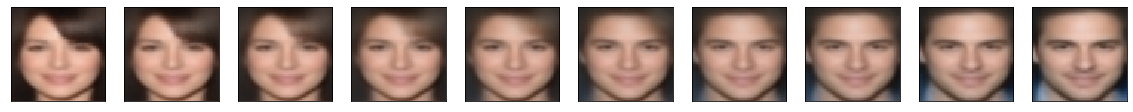

In [19]:
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(d_morph[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #plt.savefig('result/morph_vae_128.jpg', dpi=300, bbox_inches = 'tight')

## TSNE

In [20]:
tsne_path = '/home/irfandw/Works/dataset/tsne/'

In [21]:
tsne_dataset = ImageFolder(
        root=tsne_path,
        transform=torchvision.transforms.ToTensor()
    )
tsne_loader = DataLoader(
        tsne_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [22]:
def load_name(path):
    all_names = []
    all_index =  []    
    
    for root, dirs, files in os.walk(path):
        all_index.append(os.path.basename(root))
        dirs.sort()
        for file_ in files:
            all_names.append(os.path.basename(root))
                
    return all_names, all_index

all_names, indexing = load_name(tsne_path)

In [23]:
all_names

['Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',


In [24]:
d = defaultdict(count().__next__)

new_list = [d[x] for x in all_names]

new_list =  np.array(new_list)

In [25]:
VAE_net.eval()

z_tsne = []

with torch.no_grad():
    for batch_idx, data in enumerate(tsne_loader):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = VAE_net._encode(datax)
        z_tsne.append(z_encoded[0].cpu().numpy())

z_tsne = np.array(z_tsne)

In [26]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=30, n_iter=2000)

In [27]:
X_2d = tsne.fit_transform(z_tsne)

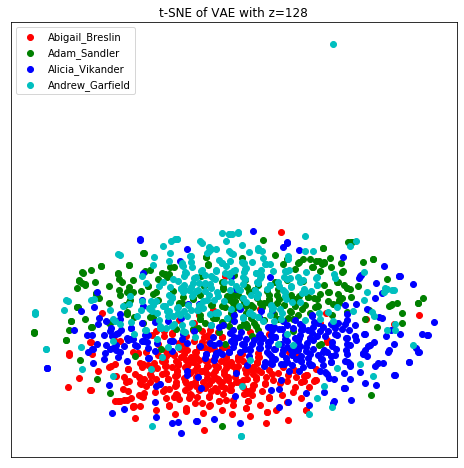

In [28]:
target_ids = range(len(indexing[1:]))

plt.figure(figsize=(8,8))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'brown', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, indexing[1:]):
    plt.scatter(X_2d[new_list == i, 0], X_2d[new_list == i, 1], c=c, label=label)


plt.title('t-SNE of VAE with z=128')      
plt.xticks([], [])
plt.yticks([], [])
plt.legend(loc="upper left")
#plt.savefig('result/04-VAE_128_tsne.jpg', dpi=300, bbox_inches = 'tight')
plt.show()